In [1]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import normalize
from pybrain.datasets import ClassificationDataSet
from pybrain.tools.shortcuts import buildNetwork
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import SoftmaxLayer
from pybrain.utilities import percentError
import xgboost as xgb
%matplotlib inline

## Цель вычислительного эксперимента

Необходимо решить задачу классификации

## Описание выборки

В выборке представлены медицинские описания онкобольных с заболеванием рака груди, также указано, произошел ли рецидив заболевания. 

Число объектов в выборке: 286.

Число признаков: 9 признаков + признак класса.

Информация о признаках:
1. Class: no-recurrence-events, recurrence-events
2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
3. menopause: lt40, ge40, premeno.
4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59.
5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39.
6. node-caps: yes, no.
7. deg-malig: 1, 2, 3.
8. breast: left, right.
9. breast-quad: left-up, left-low, right-up,	right-low, central.
10. irradiat:	yes, no.

Распределение по классам (имеем дело с несбалансированной выборкой):
1. no-recurrence-events: 201 объект
2. recurrence-events: 85 объект

Если значение признака неизвестно, в выборке указан на его месте символ "?".

## Загрузка и предобработка выборки

In [2]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data", header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
0    286 non-null object
1    286 non-null object
2    286 non-null object
3    286 non-null object
4    286 non-null object
5    286 non-null object
6    286 non-null int64
7    286 non-null object
8    286 non-null object
9    286 non-null object
dtypes: int64(1), object(9)
memory usage: 22.4+ KB


In [5]:
data = data.replace('?', np.nan)
data = data.replace('5-9', '05-09')
data = data.replace('3-5', '03-05')
data = data.replace('0-4', '0-04')
data = data.replace('0-2', '0-02')
data = data.replace('6-8', '06-08')
data = data.replace('9-11', '09-11')
data = data.replace('no-recurrence-events', 0)
data = data.replace('recurrence-events', 1)

In [6]:
pd.isnull(data.values).any()

True

In [7]:
data.shape

(286, 10)

In [8]:
data.dropna(inplace=True)

In [9]:
data.shape

(277, 10)

Т.к. с неопределенными значениями в выборке всего 9 объектов (что меньше 4% выборки), можем просто исключить их из нее.

In [10]:
data.columns = ['class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

In [11]:
data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,0,30-39,premeno,30-34,0-02,no,3,left,left_low,no
1,0,40-49,premeno,20-24,0-02,no,2,right,right_up,no
2,0,40-49,premeno,20-24,0-02,no,2,left,left_low,no
3,0,60-69,ge40,15-19,0-02,no,2,right,left_up,no
4,0,40-49,premeno,0-04,0-02,no,2,right,right_low,no


In [12]:
y = data[['class']]

In [13]:
y.head()

,class
0,0
1,0
2,0
3,0
4,0


In [14]:
X = data.drop(['class'], axis=1)

In [15]:
X.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,30-39,premeno,30-34,0-02,no,3,left,left_low,no
1,40-49,premeno,20-24,0-02,no,2,right,right_up,no
2,40-49,premeno,20-24,0-02,no,2,left,left_low,no
3,60-69,ge40,15-19,0-02,no,2,right,left_up,no
4,40-49,premeno,0-04,0-02,no,2,right,right_low,no


### Анализ состава выборки

В представленной выборке пока все признаки являются номинальными (неизвестно, можно ли сравнивать значения одного признака друг с другом). Для выделения порядковых признаков построим гистограммы.

In [16]:
less = data[data['class'] == 1]
more = data[data['class'] == 0]
more.shape

(196, 10)

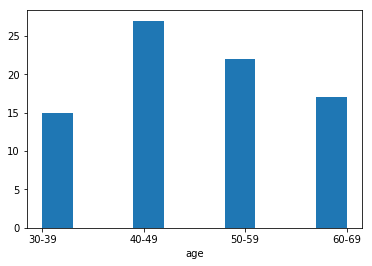

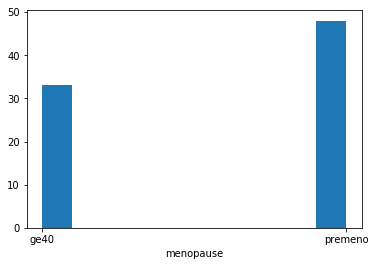

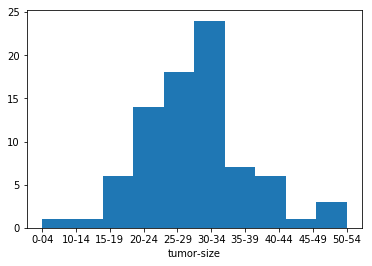

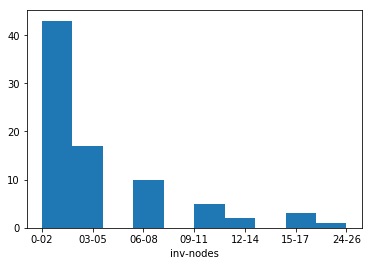

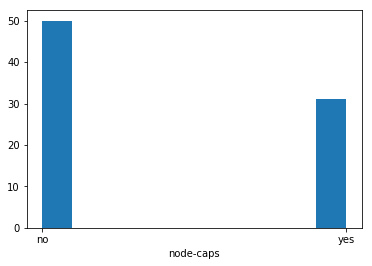

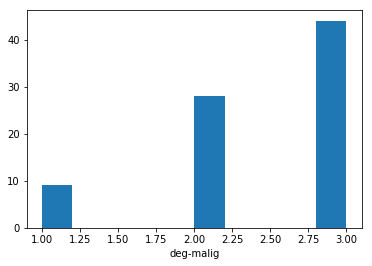

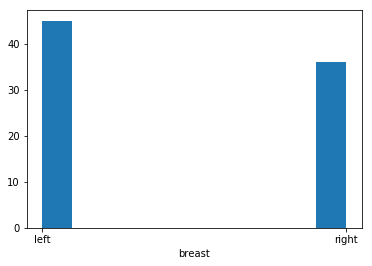

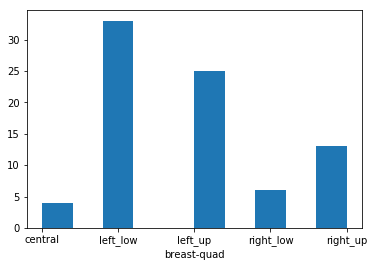

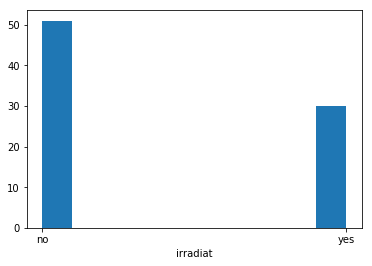

In [17]:
for i in less.columns[1:]:
    plt.hist(less[i])
    plt.xlabel(i)
    plt.show()

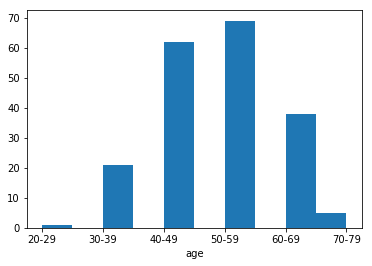

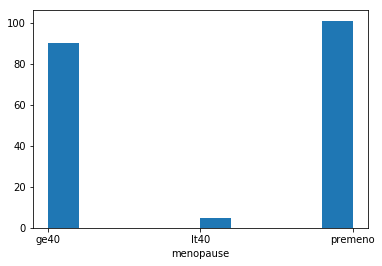

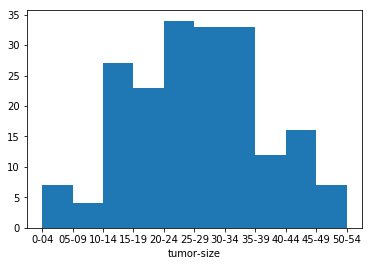

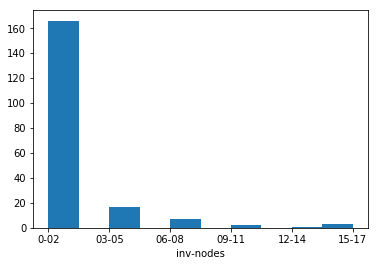

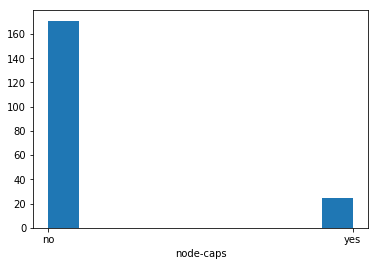

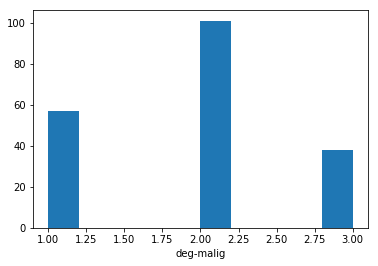

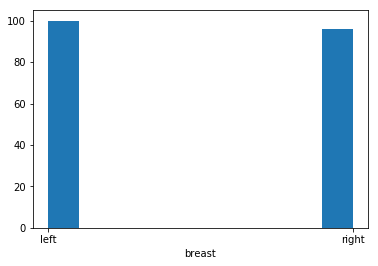

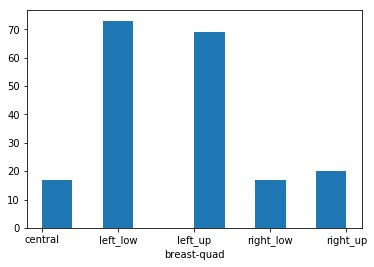

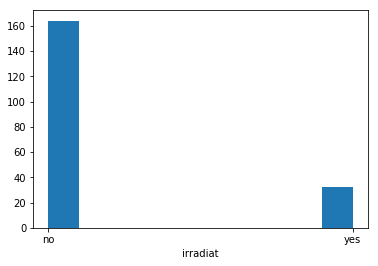

In [18]:
for i in more.columns[1:]:
    plt.hist(more[i])
    plt.xlabel(i)
    plt.show()

Из гистограмм можно сделать вывод, что признак breast не влияет на распределение внутри классов, поэтому можем его удалить

In [19]:
X.drop(['breast'], axis=1, inplace=True)

In [20]:
X.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast-quad,irradiat
0,30-39,premeno,30-34,0-02,no,3,left_low,no
1,40-49,premeno,20-24,0-02,no,2,right_up,no
2,40-49,premeno,20-24,0-02,no,2,left_low,no
3,60-69,ge40,15-19,0-02,no,2,left_up,no
4,40-49,premeno,0-04,0-02,no,2,right_low,no


Поменяем категориальные признаки на индикаторы

In [21]:
X = pd.get_dummies(X)

In [22]:
X.head()

,deg-malig,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_ge40,menopause_lt40,menopause_premeno,...,inv-nodes_24-26,node-caps_no,node-caps_yes,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes
0,3,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0
1,2,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
2,2,0,0,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0
3,2,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0


In [23]:
X.drop(['node-caps_no', 'irradiat_no'], axis=1, inplace=True)

In [24]:
X.head()

,deg-malig,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_ge40,menopause_lt40,menopause_premeno,...,inv-nodes_12-14,inv-nodes_15-17,inv-nodes_24-26,node-caps_yes,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_yes
0,3,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,2,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [25]:
X.corr()

,deg-malig,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_ge40,menopause_lt40,menopause_premeno,...,inv-nodes_12-14,inv-nodes_15-17,inv-nodes_24-26,node-caps_yes,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_yes
deg-malig,1.000000,-0.004772,0.043031,0.009116,0.007845,-0.027036,-0.085174,0.048813,-0.010748,-0.045776,...,0.135305,0.158373,0.077835,0.330181,-0.078855,-0.001251,0.058286,-0.041809,0.016729,0.230821
age_20-29,-0.004772,1.000000,-0.023264,-0.041415,-0.042103,-0.029961,-0.008161,-0.053794,-0.008161,0.055790,...,-0.006298,-0.008956,-0.003623,-0.030300,-0.017240,-0.047391,-0.043140,-0.018113,0.163675,-0.032324
age_30-39,0.043031,-0.023264,1.000000,-0.265925,-0.270338,-0.192375,-0.052401,-0.345410,0.028239,0.336690,...,-0.040442,-0.057509,-0.023264,0.019301,0.092100,0.004944,-0.050260,0.039329,-0.042713,0.050027
age_40-49,0.009116,-0.041415,-0.265925,1.000000,-0.481261,-0.342469,-0.093286,-0.474871,-0.093286,0.498160,...,0.152079,0.056941,-0.041415,0.000139,-0.109444,-0.016825,0.013027,0.073128,0.033342,0.094212
age_50-59,0.007845,-0.042103,-0.270338,-0.481261,1.000000,-0.348152,-0.094834,0.241209,0.020634,-0.245895,...,-0.073190,0.054326,-0.042103,0.049816,0.031974,0.018612,-0.014300,-0.043343,0.003769,-0.135879
age_60-69,-0.027036,-0.029961,-0.192375,-0.342469,-0.348152,1.000000,-0.067485,0.520517,0.068466,-0.537023,...,-0.052082,-0.074062,0.120932,-0.047752,-0.005801,0.036365,0.044643,-0.084184,-0.043367,0.036684
age_70-79,-0.085174,-0.008161,-0.052401,-0.093286,-0.094834,-0.067485,1.000000,0.151708,-0.018382,-0.146281,...,-0.014187,-0.020174,-0.008161,-0.068249,0.063611,-0.106747,0.017367,0.057473,0.033845,-0.072808
menopause_ge40,0.048813,-0.053794,-0.345410,-0.474871,0.241209,0.520517,0.151708,1.000000,-0.121169,-0.964229,...,-0.023315,0.016758,0.067352,-0.015675,0.073430,-0.015975,0.050025,-0.058273,-0.059514,-0.061548
menopause_lt40,-0.010748,-0.008161,0.028239,-0.093286,0.020634,0.068466,-0.018382,-0.121169,1.000000,-0.146281,...,-0.014187,-0.020174,-0.008161,-0.068249,-0.038832,0.004834,0.017367,-0.040799,0.033845,-0.072808
menopause_premeno,-0.045776,0.055790,0.336690,0.498160,-0.245895,-0.537023,-0.146281,-0.964229,-0.146281,1.000000,...,0.027024,-0.011313,-0.064943,0.033847,-0.062810,0.014629,-0.054492,0.068969,0.050273,0.080780


Как видим, признаки слабо коррелируют друг с другом.

## Список моделей

В данном задании для решения поставленной задачи будут использоваться следующие модели:
1. Логистическая регрессия
2. Нейронная сеть
3. Градиентный бустинг

## Критерии качества

В качестве критериев качества рассматриваются:
1. Точность
2. ROC AUC
3. PR кривая

## Разбиение выборки на обучение и контроль

Возьмем одну треть выборки под контроль, остальное для обучения, также обеспечим, чтобы в обучающей и контрольной выборках было одинаковое соотношение классов

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size=0.33, random_state=42, stratify=y)

## Обучение моделей и их анализ

### Логистическая регрессия

In [27]:
classifier = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
parameters_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

In [29]:
grid_cv = GridSearchCV(classifier, parameters_grid, scoring='accuracy', cv=cv)

In [30]:
grid_cv.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [31]:
grid_cv.best_params_

{'C': 0.1}

In [32]:
y_predicted = grid_cv.predict(X_test)

In [33]:
best_classifier = LogisticRegression(class_weight='balanced', C=0.1)
best_classifier.fit(X_train, np.ravel(y_train))

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [34]:
y_prob = best_classifier.predict_proba(X_test)

In [35]:
metrics.accuracy_score(np.ravel(y_test), y_predicted)

0.6847826086956522

In [36]:
metrics.roc_auc_score(np.ravel(y_test), y_predicted)

0.6686609686609687

In [37]:
fpr, tpr, _ = metrics.roc_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'True positive rate')

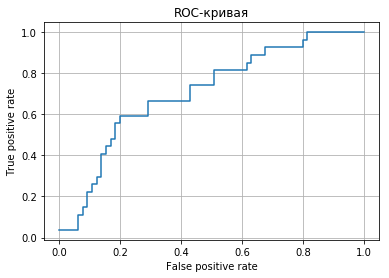

In [38]:
plt.title("ROC-кривая")
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [39]:
precision, recall, _ = metrics.precision_recall_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'Precision')

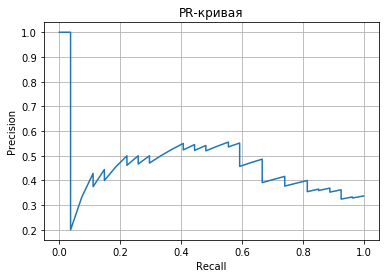

In [40]:
plt.title("PR-кривая")
plt.plot(recall, precision)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')

In [41]:
acc = np.zeros(7)
for i, c in enumerate([0.001, 0.01, 0.1, 1, 10, 100, 1000]):
    temp_classifier = LogisticRegression(class_weight='balanced', C=c)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

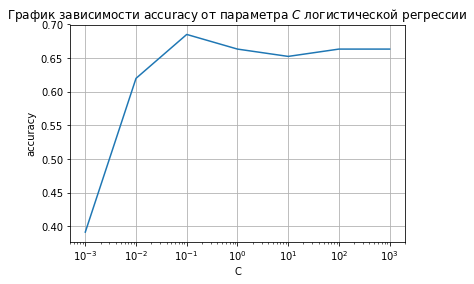

In [42]:
plt.title("График зависимости accuracy от параметра $C$ логистической регрессии")
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000], acc)
plt.grid()
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("accuracy")
plt.show()

In [43]:
y_train.size

185

In [46]:
temp_classifier = LogisticRegression(class_weight='balanced', C=0.1)
acc = np.zeros((y_train.size - 50, 7))
k = y_test.size // 7 + (y_test.size % 7 > 0)
for i in range(y_train.size - 50):
    temp_classifier.fit(X_train[:50 + i], np.ravel(y_train)[:50 + i])
    y_predicted = temp_classifier.predict(X_test)
    for j in range(7):
        acc[i][j] = metrics.accuracy_score((np.ravel(y_test))[k * j: k * (j + 1)], y_predicted[k * j: k * (j + 1)])

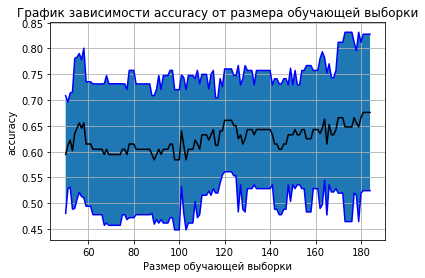

In [48]:
acc_mean = np.mean(acc, axis=1)
acc_std = np.std(acc, axis=1)
plt.title("График зависимости accuracy от размера обучающей выборки")
plt.plot(range(50, y_train.size), acc_mean, 'k-')
plt.plot(range(50, y_train.size), acc_mean - acc_std, 'b-')
plt.plot(range(50, y_train.size), acc_mean + acc_std, 'b-')
plt.fill_between(range(50, y_train.size), acc_mean - acc_std, acc_mean + acc_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("accuracy")
plt.show()

In [49]:
acc = np.zeros(1000)
for i in range(1000):
    temp_classifier = LogisticRegression(class_weight='balanced', C=0.001, max_iter=i)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

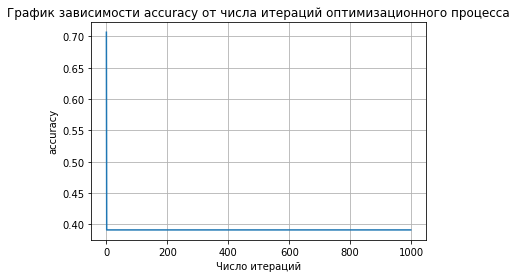

In [50]:
plt.title("График зависимости accuracy от числа итераций оптимизационного процесса")
plt.plot(range(1000), acc)
plt.grid()
plt.xlabel("Число итераций")
plt.ylabel("accuracy")
plt.show()

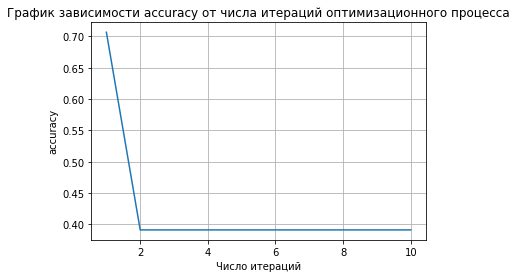

In [51]:
plt.title("График зависимости accuracy от числа итераций оптимизационного процесса")
plt.plot(range(1, 11), acc[:10])
plt.grid()
plt.xlabel("Число итераций")
plt.ylabel("accuracy")
plt.show()

### Нейронная сеть

In [52]:
ds_train = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_train.setField('input', X_train)
ds_train.setField('target', y_train)
ds_train._convertToOneOfMany()
ds_test = ClassificationDataSet(np.shape(X)[1], nb_classes=len(np.unique(y_train)))
ds_test.setField('input', X_test)
ds_test.setField('target', y_test)
ds_test._convertToOneOfMany()

In [53]:
np.random.seed(42)

net = buildNetwork(ds_train.indim, 100, ds_train.outdim, outclass=SoftmaxLayer)

init_params = np.random.random((len(net.params)))
net._setParameters(init_params)

In [54]:
random.seed(42)
trainer = BackpropTrainer(net, dataset=ds_train)
err_train, err_val = trainer.trainUntilConvergence(maxEpochs=45)

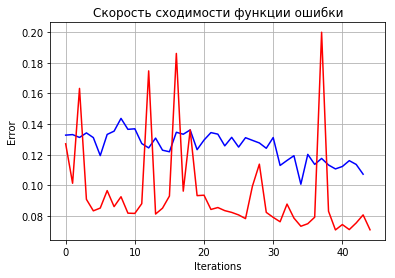

In [55]:
plt.title("Скорость сходимости функции ошибки")
plt.grid()
line_train = plt.plot(err_train, 'b', err_val, 'r') # Построение графика
xlab = plt.xlabel('Iterations')
ylab = plt.ylabel('Error')

In [56]:
res_train = net.activateOnDataset(ds_train).argmax(axis=1)
print('Error on train: ', percentError(res_train, ds_train['target'].argmax(axis=1)), '%')
res_test = net.activateOnDataset(ds_test).argmax(axis=1)
print('Error on test: ', percentError(res_test, ds_test['target'].argmax(axis=1)), '%')

Error on train:  20.0 %
Error on test:  29.347826086956523 %


In [57]:
metrics.accuracy_score(y_test, res_test)

0.7065217391304348

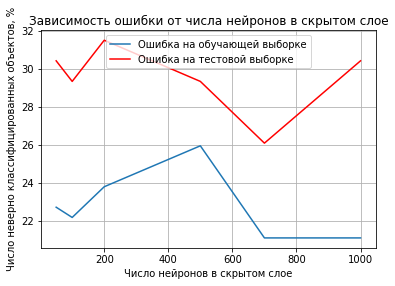

In [58]:
random.seed(42)
np.random.seed(42)

def plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec):
    plt.figure()
    plt.title('Зависимость ошибки от числа нейронов в скрытом слое')
    plt.grid()
    plt.plot(hidden_neurons_num, res_train_vec, label='Ошибка на обучающей выборке')
    plt.plot(hidden_neurons_num, res_test_vec, '-r', label='Ошибка на тестовой выборке')
    plt.legend()
    plt.xlabel('Число нейронов в скрытом слое')
    plt.ylabel('Число неверно классифицированных объектов, %')

hidden_neurons_num = [50, 100, 200, 500, 700, 1000]
res_train_vec = list()
res_test_vec = list()

for nnum in hidden_neurons_num:
    net = buildNetwork(ds_train.indim, nnum, ds_train.outdim, outclass=SoftmaxLayer)
    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)
    trainer = BackpropTrainer(net, dataset=ds_train)
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=100)
    res_train = net.activateOnDataset(ds_train).argmax(axis=1)
    res_test = net.activateOnDataset(ds_test).argmax(axis=1)
    res_train_vec.append(percentError(res_train, ds_train['target'].argmax(axis=1)))
    res_test_vec.append(percentError(res_test, ds_test['target'].argmax(axis=1)))
    
plot_classification_error(hidden_neurons_num, res_train_vec, res_test_vec) 

Построим график зависимости ошибки от числа объектов в обучающей выборке

Делаем вывод, что оптимальное число нейронов — 700.

In [59]:
random.seed(42)
np.random.seed(42)

tr_sizes = [50, 75, 100, 125, 150, 175]
res_test_vec = np.zeros((6, 7))

for i, tr in enumerate(tr_sizes):
    ds_train = ClassificationDataSet(tr, nb_classes=len(np.unique(y_train)))
    ds_train.setField('input', X_train[:tr])
    ds_train.setField('target', y_train[:tr])
    ds_train._convertToOneOfMany( )
    net = buildNetwork(ds_train.indim, 700, ds_train.outdim, outclass=SoftmaxLayer)
    init_params = np.random.random((len(net.params)))
    net._setParameters(init_params)
    trainer = BackpropTrainer(net, dataset=ds_train)
    err_train, err_val = trainer.trainUntilConvergence(maxEpochs=100)
    for j in range(7):
        ds_test = ClassificationDataSet(np.shape(X[k * j: k * (j + 1)])[1], nb_classes=len(np.unique(y_train)))
        ds_test.setField('input', X_test[k * j: k * (j + 1)])
        ds_test.setField('target', y_test[k * j: k * (j + 1)])
        ds_test._convertToOneOfMany()
        res_test = net.activateOnDataset(ds_test).argmax(axis=1)
        res_test_vec[i][j] = percentError(res_test, ds_test['target'].argmax(axis=1))

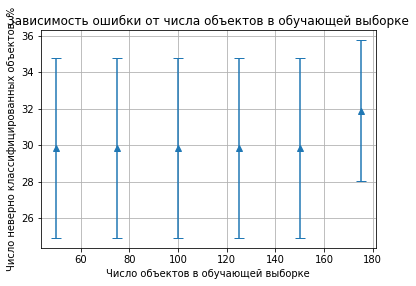

In [60]:
res_test_mean = np.mean(res_test_vec, axis = 1)
res_test_std = np.std(res_test_vec, axis = 1)
plt.title('Зависимость ошибки от числа объектов в обучающей выборке')
plt.errorbar(tr_sizes, res_test_mean, res_test_std, linestyle=' ', marker='^', capsize=5, label='Ошибка на тестовой выборке')
plt.grid()
plt.xlabel('Число объектов в обучающей выборке')
plt.ylabel('Число неверно классифицированных объектов, %')
plt.show()

### Градиентный бустинг

In [61]:
xg = xgb.XGBClassifier()

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= True, test_size=0.33, random_state=42, stratify=y)

In [63]:
parameters_grid = {
    'learning_rate' : [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'max_depth' : [3, 4, 5, 7, 9, 11],
    'n_estimators' : [5, 7, 10, 13, 15, 17, 20, 25, 30, 35, 40, 45, 50, 55, 60]
}

In [64]:
grid_cv = GridSearchCV(xg, parameters_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
grid_cv.fit(X_train, np.ravel(y_train))
print('best_score', grid_cv.best_score_)
print('best_params', grid_cv.best_params_)

best_score 0.7183070483070484
best_params {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 10}


In [67]:
best_classifier = xgb.XGBClassifier(learning_rate=0.5, max_depth=4, n_estimators=10)
best_classifier.fit(X_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [68]:
y_predicted = grid_cv.predict(X_test)
y_prob = best_classifier.predict_proba(X_test)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [69]:
metrics.accuracy_score(np.ravel(y_test), y_predicted)

0.75

In [70]:
metrics.roc_auc_score(np.ravel(y_test), y_predicted)

0.639031339031339

In [71]:
fpr, tpr, _ = metrics.roc_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'True positive rate')

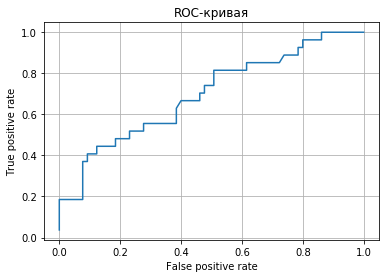

In [72]:
plt.title("ROC-кривая")
plt.plot(fpr, tpr)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [73]:
precision, recall, _ = metrics.precision_recall_curve(np.ravel(y_test), y_prob[:, 1])

Text(0,0.5,'Precision')

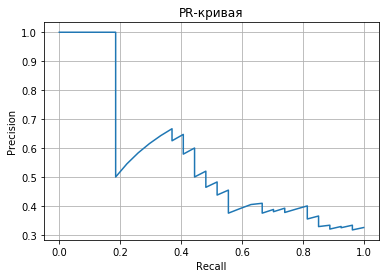

In [74]:
plt.title("PR-кривая")
plt.plot(recall, precision)
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')

In [75]:
acc = np.zeros(6)
for i, learn in enumerate([0.1, 0.3, 0.4, 0.5, 0.6, 0.7]):
    temp_classifier = xgb.XGBClassifier(learning_rate=learn, max_depth=4, n_estimators=10)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

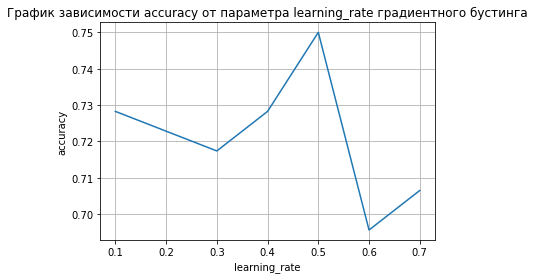

In [76]:
plt.title("График зависимости accuracy от параметра learning_rate градиентного бустинга")
plt.plot([0.1, 0.3, 0.4, 0.5, 0.6, 0.7], acc)
plt.grid()
plt.xlabel("learning_rate")
plt.ylabel("accuracy")
plt.show()

In [77]:
acc = np.zeros(6)
for i, depth in enumerate([3, 4, 5, 6, 7, 9]):
    temp_classifier = xgb.XGBClassifier(learning_rate=0.5, max_depth=depth, n_estimators=10)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

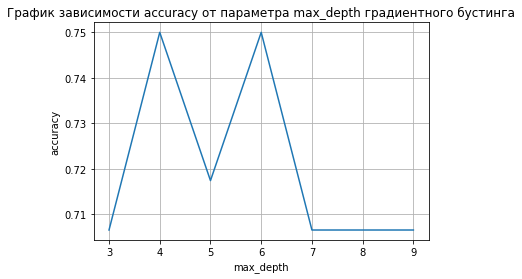

In [78]:
plt.title("График зависимости accuracy от параметра max_depth градиентного бустинга")
plt.plot([3, 4, 5, 6, 7, 9], acc)
plt.grid()
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.show()

In [79]:
acc = np.zeros(8)
for i, est in enumerate([5, 10, 15, 20, 25, 30, 35, 40]):
    temp_classifier = xgb.XGBClassifier(learning_rate=0.5, max_depth=4, n_estimators=est)
    temp_classifier.fit(X_train, np.ravel(y_train))
    y_predicted = temp_classifier.predict(X_test)
    acc[i] = metrics.accuracy_score(np.ravel(y_test), y_predicted)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

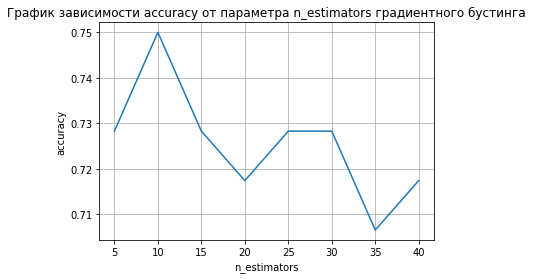

In [80]:
plt.title("График зависимости accuracy от параметра n_estimators градиентного бустинга")
plt.plot([5, 10, 15, 20, 25, 30, 35, 40], acc)
plt.grid()
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()

In [82]:
temp_classifier = xgb.XGBClassifier(learning_rate=0.3, max_depth=5, n_estimators=30)
acc = np.zeros((y_train.size - 50, 7))
k = y_test.size // 7 + (y_test.size % 7 > 0)
for i in range(y_train.size - 50):
    temp_classifier.fit(X_train[:50 + i], np.ravel(y_train)[:50 + i])
    y_predicted = temp_classifier.predict(X_test)
    for j in range(7):
        acc[i][j] = metrics.accuracy_score((np.ravel(y_test))[k * j: k * (j + 1)], y_predicted[k * j: k * (j + 1)])

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `arra

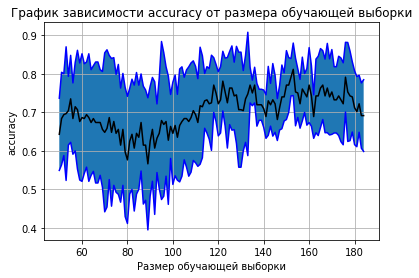

In [83]:
acc_mean = np.mean(acc, axis=1)
acc_std = np.std(acc, axis=1)
plt.title("График зависимости accuracy от размера обучающей выборки")
plt.plot(range(50, y_train.size), acc_mean, 'k-')
plt.plot(range(50, y_train.size), acc_mean - acc_std, 'b-')
plt.plot(range(50, y_train.size), acc_mean + acc_std, 'b-')
plt.fill_between(range(50, y_train.size), acc_mean - acc_std, acc_mean + acc_std)
plt.grid()
plt.xlabel("Размер обучающей выборки")
plt.ylabel("accuracy")
plt.show()